# Previsão das Notas de Matemática do ENEM 2016

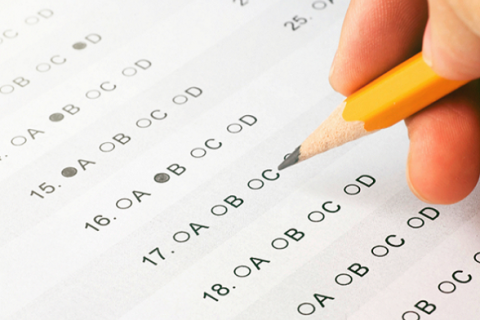

In [1]:
from IPython.display import Image
Image('foto.png')

O desafio aqui é criar um modelo para prever a nota da prova de matemática de quem participou do ENEM 2016.

Para isso, foi disponibilizado os dados de parte dos alunos que participaram da prova. Com base nesses dados, devo criar um modelo preditivo que seja capaz de aprender a relação entre os dados disponibilizados e, assim, fazer previsões sobre novos dados. A previsão que queremos aqui é a nota de matemática.

Num primeiro momento, já é possível dizer que se trata de um problema de Regressão e que a variável alvo é a nota de matemática. Agora analisarei os dados contidos no dataset.

### Análise Exploratória

In [2]:
# Importação das bibliotecas:
import pandas as pd
import numpy as np
import scipy.stats as stats
import sklearn
import math
from sklearn.model_selection import train_test_split

import warnings 
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [3]:
# Leitura dos arquivos e instanciar os datasets:
df_train = pd.read_csv('train.csv', sep="," , encoding="UTF8")
df_test = pd.read_csv('test.csv', sep="," , encoding="UTF8")

In [4]:
# Dimensões dos datasets:
print("Dimesão do dataset de treino:\nLinhas: {}\nColunas: {}".format(df_train.shape[0], df_train.shape[1]))
print("Dimesão do dataset de teste:\nLinhas: {}\nColunas: {}".format(df_test.shape[0], df_test.shape[1]))

Dimesão do dataset de treino:
Linhas: 13730
Colunas: 167
Dimesão do dataset de teste:
Linhas: 4576
Colunas: 47


In [5]:
df_train.shape[1] - df_test.shape[1]

120

Aqui, a primeira percepção é que se trata de um dataset de grande dimensionalidade - são 167 colunas/atributos no dataset de treino. Isso pode afetar a performance do modelo preditivo se muitas dessas variáveis forem relevantes para o modelo. Se esse for o caso, usarei técnicas para redução de dimensionalidade. 

Porém, olhando para o tamanho dos datasets de treino e de teste, percebe-se que já é possível eliminar 120 variáveis dos dados de treino, pois estas não estão presentes no dataset de teste. Portanto, essas variáveis não serão usadas para as previsões, logo não faz sentido usá-las para treinamento.

Então, nesse primeiro momento, irei manter as variáveis do dataset de treino comuns ao dataset de teste.

Observação: A partir daqui, farei alterações nos datasets originais. Para que um histórico dessas alterações fique registrado, salvarei as novas versões do dataframe da seguinte forma: df_train_1, df_train_2 e assim por diante.

In [6]:
# Ainda, o dataset de treino manterá a variável NU_NOTA_MT (variável target):
cols = list(set(df_train.columns).intersection(set(df_test.columns)))
cols.append('NU_NOTA_MT')
df_train_1 = df_train[cols].copy()
print(df_train_1.shape, df_test.shape)

(13730, 48) (4576, 47)


In [7]:
# Visualização das variáveis:
df_train_1.head(2)

,IN_SURDEZ,TP_COR_RACA,TP_ANO_CONCLUIU,NU_NOTA_COMP5,IN_DISLEXIA,Q006,CO_PROVA_CN,IN_BAIXA_VISAO,IN_TREINEIRO,Q001,...,TP_STATUS_REDACAO,TP_PRESENCA_CN,NU_NOTA_LC,NU_NOTA_CH,IN_DISCALCULIA,IN_GESTANTE,NU_NOTA_CN,IN_SABATISTA,Q027,NU_NOTA_MT
0,0,1,4,80.0,0,C,16f84b7b3d2aeaff7d2f01297e6b3d0e25c77bb2,0,0,D,...,1.0,1,581.2,495.4,0,0,436.3,0,H,399.4
1,0,3,0,80.0,0,B,b9b06ce8c319a3df2158ea3d0aef0f7d3eecaed7,0,0,A,...,1.0,1,599.0,544.1,0,0,474.5,0,NaN,459.8


In [8]:
df_train_1.columns

Index(['IN_SURDEZ', 'TP_COR_RACA', 'TP_ANO_CONCLUIU', 'NU_NOTA_COMP5',
       'IN_DISLEXIA', 'Q006', 'CO_PROVA_CN', 'IN_BAIXA_VISAO', 'IN_TREINEIRO',
       'Q001', 'TP_ESCOLA', 'IN_IDOSO', 'CO_PROVA_CH', 'IN_CEGUEIRA',
       'TP_SEXO', 'Q002', 'TP_ST_CONCLUSAO', 'CO_PROVA_LC', 'SG_UF_RESIDENCIA',
       'Q025', 'Q047', 'TP_PRESENCA_LC', 'TP_ENSINO', 'NU_NOTA_COMP2',
       'TP_DEPENDENCIA_ADM_ESC', 'NU_INSCRICAO', 'CO_PROVA_MT', 'Q024',
       'NU_NOTA_COMP1', 'TP_NACIONALIDADE', 'TP_PRESENCA_CH', 'Q026',
       'NU_NOTA_COMP3', 'NU_NOTA_COMP4', 'CO_UF_RESIDENCIA', 'NU_NOTA_REDACAO',
       'TP_LINGUA', 'NU_IDADE', 'TP_STATUS_REDACAO', 'TP_PRESENCA_CN',
       'NU_NOTA_LC', 'NU_NOTA_CH', 'IN_DISCALCULIA', 'IN_GESTANTE',
       'NU_NOTA_CN', 'IN_SABATISTA', 'Q027', 'NU_NOTA_MT'],
      dtype='object')

Outra percepção quanto as variáveis é que, aquelas que representam códigos não são relevantes ao modelo, logo eliminarei essas variáveis também. Lembrando que o que eu modificar no dataset de treino, tenho que modificar no dataset de teste.

In [9]:
# Deletar as variáveis que representam códigos:
df_train_2 = df_train_1.drop(['CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_CN', 'CO_PROVA_MT', 
                 'CO_UF_RESIDENCIA'], axis = 1)
df_test_1 = df_test.drop(['CO_PROVA_CH', 'CO_PROVA_LC', 'CO_PROVA_CN', 'CO_PROVA_MT', 
                 'CO_UF_RESIDENCIA'], axis = 1)

In [10]:
print(df_train_2.shape, df_test_1.shape)

(13730, 43) (4576, 42)


### Pré-processamento dos dados

#### Feature Selection:

Aqui verificarei a correlação das variáveis com a variável target para então selecionar as melhores variáveis e aplicar transformações, se necessário.

In [11]:
# Verificar todas as correlações com a variável target:
df_train_2.corr().NU_NOTA_MT

IN_SURDEZ                -0.015249
TP_COR_RACA              -0.157364
TP_ANO_CONCLUIU           0.029039
NU_NOTA_COMP5             0.343337
IN_DISLEXIA               0.001453
IN_BAIXA_VISAO            0.000685
IN_TREINEIRO             -0.022287
TP_ESCOLA                 0.069304
IN_IDOSO                 -0.011336
IN_CEGUEIRA                    NaN
TP_ST_CONCLUSAO          -0.087869
TP_PRESENCA_LC                 NaN
TP_ENSINO                -0.086353
NU_NOTA_COMP2             0.335638
TP_DEPENDENCIA_ADM_ESC    0.373233
NU_NOTA_COMP1             0.299402
TP_NACIONALIDADE         -0.034965
TP_PRESENCA_CH            0.003552
NU_NOTA_COMP3             0.350307
NU_NOTA_COMP4             0.342282
NU_NOTA_REDACAO           0.379376
TP_LINGUA                -0.201726
NU_IDADE                 -0.061485
TP_STATUS_REDACAO        -0.059376
TP_PRESENCA_CN            0.003552
NU_NOTA_LC                0.494695
NU_NOTA_CH                0.529594
IN_DISCALCULIA            0.009813
IN_GESTANTE         

Duas variáveis foram acusadas como NaN na correlação com a variável target - analisarei essas variáveis, começando pela "IN_CEGUEIRA".

In [12]:
df_train_2.IN_CEGUEIRA.describe()

count    13730.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: IN_CEGUEIRA, dtype: float64

In [13]:
df_train_2.IN_CEGUEIRA.isnull().sum()

0

Aqui vê-se que a variável "IN_CEGUEIRA" está com todos os seus registros marcados como "0" o que significa, de acordo com o dicionário disponibilizado, que nenhum aluno acusou essa condição no ato da inscrição. Como essa variável não apresenta nenhuma variância (todos os registros são zero), ela não é relevante para o modelo. Logo, ela não será selecionada para treinar o modelo.

Agora analisarei a variável "TP_PRESENCA_LC" que representa a presença do aluno na prova de Linguagens e Códigos.

In [14]:
df_train_2.TP_PRESENCA_LC.describe()

count    13730.000000
mean         0.738747
std          0.440162
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          2.000000
Name: TP_PRESENCA_LC, dtype: float64

In [15]:
df_train_2.TP_PRESENCA_LC.isnull().sum()

0

In [16]:
df_train_2.groupby("TP_PRESENCA_LC").size()

TP_PRESENCA_LC
0     3592
1    10133
2        5
dtype: int64

Aqui, percebe-se que apenas 5 alunos foram eliminados (2), uma parte faltou (0) e a maior parte compareceu (1).

In [17]:
df_train_2[df_train_2["TP_PRESENCA_LC"] == 0].NU_NOTA_MT.isnull().sum()

3592

In [18]:
df_train_2[df_train_2["TP_PRESENCA_LC"] == 1].NU_NOTA_MT.isnull().sum()

0

In [19]:
df_train_2[df_train_2["TP_PRESENCA_LC"] == 2].NU_NOTA_MT.isnull().sum()

5

Imagino que a correlação acusada como NaN entre as variáveis "NU_NOTA_MT" e "TP_PRESENCA_LC" é explicada pelo fato de apenas haver registros de nota de matemática (MT) para os alunos que estiveram presentes na prova de Linguagens e Códigos (LC). Isso fica claro quando observamos o fato de que essas provas acontecem no mesmo dia. Logo, o aluno que, por algum motivo, não fez a prova de LC, também não fez a prova de MT.

Assim, como só se tem os registros de nota de MT para os alunos presentes na prova de LC, não faz sentido considerar essa variável. Mesmo que, mais tarde, eu faça uma imputação nas notas de MT ausentes, ainda não faria sentido a relação da não presença na prova de LC com as possíveis notas imputadas, sendo que a presença na prova de LC é também a presença na prova de MT. 

Portanto, a variável "TP_PRESENCA_LC" também não será considerada para o treinamento do modelo.

_ _ _ 

Agora, com base na análise de correlação, selecionarei as variáveis com correlação >=0.2 nas direções positiva e negativa para a visualizar de maneira mais clara a relação entre as variáveis no mapa de calor. 

In [20]:
df_correlation = df_train_2.corr()

In [21]:
pos_correlation = df_correlation[df_correlation['NU_NOTA_MT']>0.2]
neg_correlation = df_correlation[df_correlation['NU_NOTA_MT']<-0.2]

In [22]:
df_greatest_correlation = pd.concat([pos_correlation, neg_correlation])
# Dataframe com as maiores correlações segundo a métrica (>=+-0.2)
df_greatest_correlation

,IN_SURDEZ,TP_COR_RACA,TP_ANO_CONCLUIU,NU_NOTA_COMP5,IN_DISLEXIA,IN_BAIXA_VISAO,IN_TREINEIRO,TP_ESCOLA,IN_IDOSO,IN_CEGUEIRA,...,NU_IDADE,TP_STATUS_REDACAO,TP_PRESENCA_CN,NU_NOTA_LC,NU_NOTA_CH,IN_DISCALCULIA,IN_GESTANTE,NU_NOTA_CN,IN_SABATISTA,NU_NOTA_MT
NU_NOTA_COMP5,-0.021283,-0.091136,0.003954,1.000000,0.016754,-0.013298,-0.025811,0.071172,0.000606,NaN,...,-0.086709,-0.261122,0.026419,0.441696,0.494798,0.005220,0.003520,0.416349,0.006091,0.343337
NU_NOTA_COMP2,-0.016886,-0.090291,0.006023,0.655915,0.003853,-0.018751,-0.023308,0.084441,0.002381,NaN,...,-0.114181,-0.482149,0.022288,0.453262,0.488050,0.002381,0.004762,0.412894,0.019780,0.335638
TP_DEPENDENCIA_ADM_ESC,-0.023510,-0.172229,NaN,0.252388,NaN,-0.033257,NaN,0.975328,NaN,NaN,...,-0.082980,-0.049705,0.096449,0.299387,0.338486,0.038079,-0.008037,0.393774,0.002384,0.373233
NU_NOTA_COMP1,-0.029672,-0.097606,0.027881,0.558587,0.001727,-0.027909,-0.008709,0.059108,-0.013253,NaN,...,-0.102243,-0.583467,0.023033,0.430603,0.443809,0.000063,0.010113,0.357672,0.020032,0.299402
NU_NOTA_COMP3,-0.032884,-0.096344,0.011259,0.664350,0.005258,-0.020515,-0.030147,0.079996,-0.007760,NaN,...,-0.104293,-0.452122,0.023703,0.475390,0.510452,-0.007760,0.004731,0.429447,0.012722,0.350307
NU_NOTA_COMP4,-0.033759,-0.102936,0.022018,0.635018,0.003524,-0.023665,-0.025958,0.068909,0.002040,NaN,...,-0.110452,-0.491102,0.028095,0.467356,0.488797,0.002040,-0.004822,0.407747,0.025276,0.342282
NU_NOTA_REDACAO,-0.030017,-0.107840,0.015097,0.816248,0.007788,-0.022911,-0.026328,0.082520,-0.003158,NaN,...,-0.116125,-0.498365,0.028075,0.512908,0.550582,0.000705,0.003987,0.459938,0.018216,0.379376
NU_NOTA_LC,-0.029438,-0.168624,0.077917,0.441696,0.014425,0.000096,-0.028261,0.037254,-0.009528,NaN,...,-0.024979,-0.117688,0.007395,1.000000,0.692988,-0.003901,0.004152,0.545667,-0.007455,0.494695
NU_NOTA_CH,-0.027480,-0.161831,0.088827,0.494798,0.011557,-0.005793,-0.053460,0.052710,-0.008385,NaN,...,-0.001611,-0.114706,NaN,0.692988,1.000000,-0.004717,-0.003354,0.609543,0.011488,0.529594
NU_NOTA_CN,-0.012686,-0.149429,0.040447,0.416349,0.006516,-0.007359,-0.037874,0.083383,-0.003126,NaN,...,-0.056171,-0.081150,NaN,0.545667,0.609543,-0.000580,-0.009447,1.000000,-0.009965,0.584941


In [23]:
# Lista com as variáveis mais relevantes de acordo a primeira métrica (corr > - + 0.2)
features_selected_1 = list(df_greatest_correlation.drop('NU_NOTA_MT').index)

In [24]:
len(features_selected_1)

11

Por enquanto, estou com 11 features selecionadas para o treinamento do modelo.

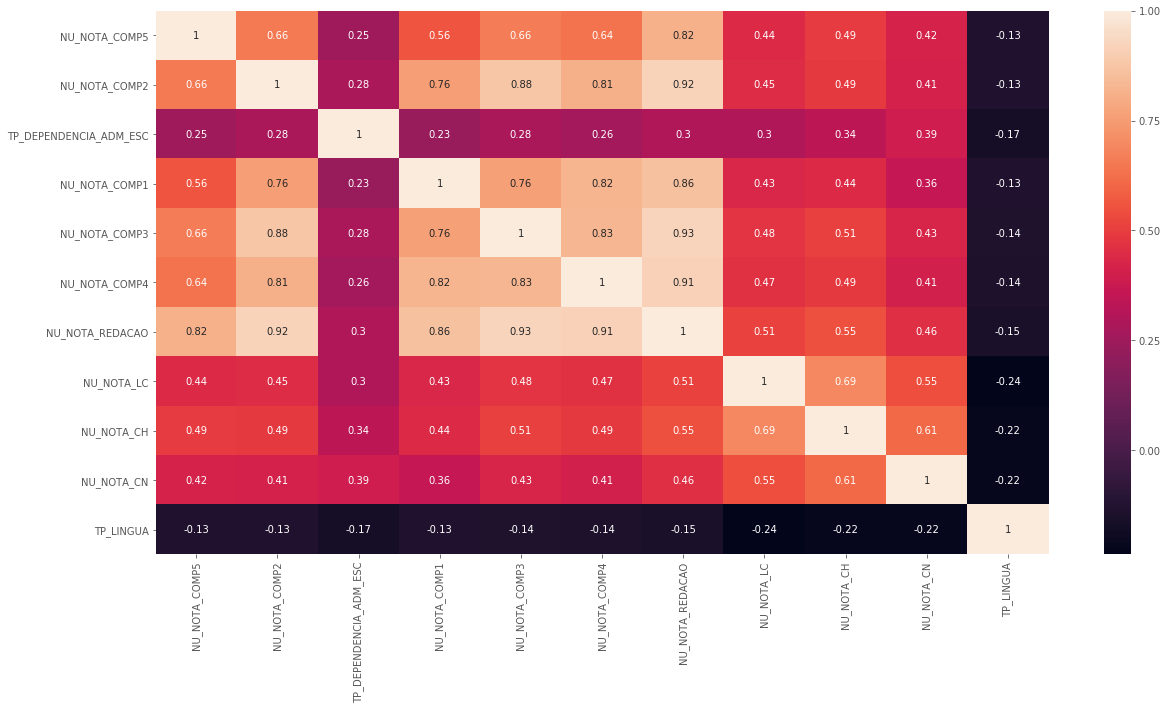

In [25]:
# Verificar correlações de features selecionadas:
plt.style.use('ggplot')
corr = df_train_2[features_selected_1].corr()
ax = plt.subplots(figsize=(20, 10))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10})

A variável "TP_LINGUA" precisa ser melhor apresentada para o modelo, já que ela está no formato 0 (alunos que optaram por Ingles) e 1 (alunos que optaram por Espanhol). Analisarei os alunos que optaram por uma língua ou outra e, em seguida, criarei outras duas variáveis 'ESPANHOL' e 'INGLES' representando as opções que os alunos tomaram. 

In [26]:
# Analisando as notas de matemática dos alunos que optaram por Espanhol:
df_train_1[df_train_1['TP_LINGUA'] == 1].NU_NOTA_MT.describe()

count    5868.000000
mean      465.330709
std        86.212529
min         0.000000
25%       402.200000
50%       448.400000
75%       512.100000
max       840.900000
Name: NU_NOTA_MT, dtype: float64

In [27]:
# Analisando as notas de matemática dos alunos que optaram por Ingles:
df_train_1[df_train_1['TP_LINGUA'] == 0].NU_NOTA_MT.describe()

count    4265.000000
mean      506.117444
std       111.753631
min         0.000000
25%       421.500000
50%       483.100000
75%       573.400000
max       952.000000
Name: NU_NOTA_MT, dtype: float64

Para a variável "TP_LINGUA", criarei 2 novas variáveis que representarão a escolha por espanhol e ingles.

In [28]:
Espanhol = []
Ingles = []
for i in list(df_train_2["TP_LINGUA"]):
    if i == 1:
        Espanhol.append(i)
    else:
        Espanhol.append(0)
    if i == 0:
        Ingles.append(1)
    else:
        Ingles.append(0)

In [29]:
df_train_2["ESPANHOL"] = Espanhol
df_train_2["INGLES"] = Ingles

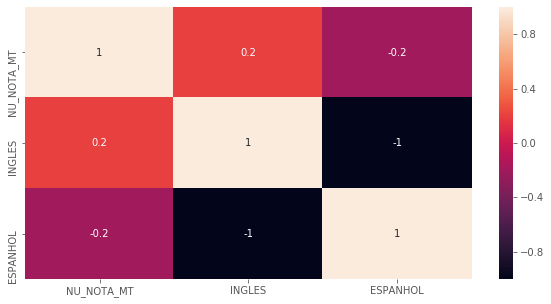

In [30]:
# Analisar a correlação com a nota de MT:
plt.style.use('ggplot')
features_corr = ['NU_NOTA_MT',
                 'INGLES', 
                 'ESPANHOL']
corr = df_train_2[features_corr].corr()
ax = plt.subplots(figsize=(10, 5))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10})

Selecionarei essas duas novas variáveis ('ESPANHOL' e 'INGLES') para o treinamento do modelo.

In [31]:
# Antes, preciso tabmém criar essas 2 variáveis no dataset de teste
Espanhol_test = []
Ingles_test = []
for i in list(df_test_1["TP_LINGUA"]):
    if i == 1:
        Espanhol_test.append(i)
    else:
        Espanhol_test.append(0)
    if i == 0:
        Ingles_test.append(1)
    else:
        Ingles_test.append(0)

In [32]:
df_test_1["ESPANHOL"] = Espanhol_test
df_test_1["INGLES"] = Ingles_test

In [33]:
features_selected_1[10]

'TP_LINGUA'

In [34]:
del(features_selected_1[10])
features_selected_2 = features_selected_1 + ['ESPANHOL', 'INGLES'] 

In [35]:
features_selected_2

['NU_NOTA_COMP5',
 'NU_NOTA_COMP2',
 'TP_DEPENDENCIA_ADM_ESC',
 'NU_NOTA_COMP1',
 'NU_NOTA_COMP3',
 'NU_NOTA_COMP4',
 'NU_NOTA_REDACAO',
 'NU_NOTA_LC',
 'NU_NOTA_CH',
 'NU_NOTA_CN',
 'ESPANHOL',
 'INGLES']

Agora olharei para as correlações entre variáveis.

In [36]:
# Verificar a correlação entre as variáveis de entrada
df_train_2[features_selected_2].corr()

,NU_NOTA_COMP5,NU_NOTA_COMP2,TP_DEPENDENCIA_ADM_ESC,NU_NOTA_COMP1,NU_NOTA_COMP3,NU_NOTA_COMP4,NU_NOTA_REDACAO,NU_NOTA_LC,NU_NOTA_CH,NU_NOTA_CN,ESPANHOL,INGLES
NU_NOTA_COMP5,1.000000,0.655915,0.252388,0.558587,0.664350,0.635018,0.816248,0.441696,0.494798,0.416349,-0.132294,0.132294
NU_NOTA_COMP2,0.655915,1.000000,0.282586,0.756664,0.875447,0.808006,0.918278,0.453262,0.488050,0.412894,-0.133054,0.133054
TP_DEPENDENCIA_ADM_ESC,0.252388,0.282586,1.000000,0.233368,0.282997,0.264291,0.297040,0.299387,0.338486,0.393774,-0.165051,0.165051
NU_NOTA_COMP1,0.558587,0.756664,0.233368,1.000000,0.759452,0.824538,0.862744,0.430603,0.443809,0.357672,-0.134679,0.134679
NU_NOTA_COMP3,0.664350,0.875447,0.282997,0.759452,1.000000,0.827151,0.925813,0.475390,0.510452,0.429447,-0.139382,0.139382
NU_NOTA_COMP4,0.635018,0.808006,0.264291,0.824538,0.827151,1.000000,0.914505,0.467356,0.488797,0.407747,-0.142948,0.142948
NU_NOTA_REDACAO,0.816248,0.918278,0.297040,0.862744,0.925813,0.914505,1.000000,0.512908,0.550582,0.459938,-0.154111,0.154111
NU_NOTA_LC,0.441696,0.453262,0.299387,0.430603,0.475390,0.467356,0.512908,1.000000,0.692988,0.545667,-0.236956,0.236956
NU_NOTA_CH,0.494798,0.488050,0.338486,0.443809,0.510452,0.488797,0.550582,0.692988,1.000000,0.609543,-0.219352,0.219352
NU_NOTA_CN,0.416349,0.412894,0.393774,0.357672,0.429447,0.407747,0.459938,0.545667,0.609543,1.000000,-0.217892,0.217892


Percebe-se que todas as notas parciais da redação são extramamente correlacionadas, isso significa que essas variáveis representam a mesma informação, então manterei apenas a nota final da redação.

E finalmente, as features selecionadas são:

In [37]:
features = [ 'NU_NOTA_REDACAO',
     'TP_DEPENDENCIA_ADM_ESC',
     'NU_NOTA_CH',
     'NU_NOTA_CN',
     'NU_NOTA_LC',
     'INGLES',
     'ESPANHOL']
target = ['NU_NOTA_MT']

## Valores Ausentes

Vou agora olhar para os valores que estão ausentes nas variáveis selecionadas.

In [38]:
# Verificar a quantidade de valores não preenchidos dentro das features selecionadas:
df_train_2[features].isnull().sum()

NU_NOTA_REDACAO           3597
TP_DEPENDENCIA_ADM_ESC    9448
NU_NOTA_CH                3389
NU_NOTA_CN                3389
NU_NOTA_LC                3597
INGLES                       0
ESPANHOL                     0
dtype: int64

Analisarei a variável "TP_DEPENDENCIA_ADM_ESC"

In [39]:
print("Porcentagem de valores NaN: {}%".format(round(df_train_2["TP_DEPENDENCIA_ADM_ESC"].isnull().sum()/len(df_train_1)*100,2)))

Porcentagem de valores NaN: 68.81%


O problema com a variável'TP_DEPENDENCIA_ADM_ESC' é que quase 69% é valor NaN. Nesse caso, ou eu faço imputação ou não considero essa variável. Vou fazer imputação com a média e ver como fica a correlação com a nota de matemática.

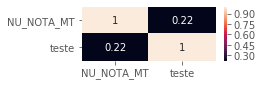

In [40]:
# Teste: preeencher os valores NaN da variável 'TP_DEPENDENCIA_ADM_ESC' e verificar novamente a correlação:
df_train_2['teste'] = df_train_2['TP_DEPENDENCIA_ADM_ESC'].fillna(df_train_2['TP_DEPENDENCIA_ADM_ESC'].mean())
plt.style.use('ggplot')
features_corr = ['NU_NOTA_MT',
                 'teste',]
corr = df_train_2[features_corr].corr()
ax = plt.subplots(figsize=(3, 1))
sns.heatmap(corr,  annot=True, annot_kws={"size": 10})

In [41]:
df_greatest_correlation.NU_NOTA_MT.TP_DEPENDENCIA_ADM_ESC

0.37323308997196825

Percebe-se que a maior correlação antes da imputação (0.37) pode estar ligada ao fato de ter muito pouco registro nessa variável, acusando uma falsa alta correlação. Como a quantidade de registros faltante é muito grande, eu não usaria essa variável para o treinamento do modelo. Porém, depois de testar a sumissão com a variável imputada com a média e sem considerar a variável, o score com a presença dela foi maior. 

Então, considerarei essa variável imputada com a média para o treinamento do modelo.

In [42]:
df_train_2['TP_DEPENDENCIA_ADM_ESC'] = df_train_2['TP_DEPENDENCIA_ADM_ESC'].fillna(df_train_2['TP_DEPENDENCIA_ADM_ESC'].mean())

In [43]:
# Fazer o mesmo para o dataset de teste:
df_test_1['TP_DEPENDENCIA_ADM_ESC'] = df_test_1['TP_DEPENDENCIA_ADM_ESC'].fillna(df_test_1['TP_DEPENDENCIA_ADM_ESC'].mean())

Como os outros valores que estão faltando se referem às notas, vou verificar a presença do aluno na prova de matemática, variável que está do dataset de treino original.

In [44]:
# Verificar os alunos que fizerem a prova de matemática:
# Dataframe que contém apenas os alunos que compareceram na prova de matemática;
df_verifica = df_train_2.loc[(df_train['TP_PRESENCA_MT'] == 1)]
print("Quantidade de alunos que estavam presentes na prova de matemática: {}".format(df_verifica.shape[0]))
print("Quantidade de alunos que faltaram na prova de matemática: {}".format(df_train.shape[0] - df_verifica.shape[0]))

Quantidade de alunos que estavam presentes na prova de matemática: 10133
Quantidade de alunos que faltaram na prova de matemática: 3597


In [45]:
df_verifica[features].isnull().sum()

NU_NOTA_REDACAO            0
TP_DEPENDENCIA_ADM_ESC     0
NU_NOTA_CH                36
NU_NOTA_CN                36
NU_NOTA_LC                 0
INGLES                     0
ESPANHOL                   0
dtype: int64

Percebe-se que a prova de LC (Liguagens e Códigos) e Redação acontece no mesmo dia que a prova de MT (matemática). Outro insight é que 36 alunos fizeram a prova de matemática mas provavelmente faltaram nas provas de CN (Ciencias da Natureza) e CH (Ciencias Humanas). 

Para esses 36 valores faltantes, eu poderia fazer imputação ou eliminar esses registros. Eliminá-los seria coerente já que eles representam apenas 0,26% do dataset:

In [46]:
print("Porcentagem de valores NaN para as notas de CN e CH: {}%".format(round(df_verifica.NU_NOTA_CN.isnull().sum()/len(df_train_1)*100,2)))

Porcentagem de valores NaN para as notas de CN e CH: 0.26%


In [47]:
df_train_2.NU_NOTA_MT.isnull().sum()

3597

De modo geral, selecionarei apenas os alunos que fizeram a prova de LC e consequentemente de MT e que não estão com valores NaN ou zero simultâneamente em todas as provas:

In [48]:
df_train_2 = df_train_2.loc[(df_train_2['TP_PRESENCA_LC'] == 1)
    & (df_train_2['NU_NOTA_CN'].notnull())  & (df_train_2['NU_NOTA_CN'] != 0) 
    & (df_train_2['NU_NOTA_CH'].notnull())      & (df_train_2['NU_NOTA_CH'] != 0) 
    & (df_train_2['NU_NOTA_LC'].notnull())  & (df_train_2['NU_NOTA_LC'] != 0) 
    & (df_train_2['NU_NOTA_REDACAO'].notnull()) & (df_train_2['NU_NOTA_REDACAO'] != 0)]

In [49]:
# Verificar que não se tem mais valores NaN:
df_train_2[features].isnull().sum()

NU_NOTA_REDACAO           0
TP_DEPENDENCIA_ADM_ESC    0
NU_NOTA_CH                0
NU_NOTA_CN                0
NU_NOTA_LC                0
INGLES                    0
ESPANHOL                  0
dtype: int64

In [50]:
print("Total de registros eliminados: {}%".format(round((df_train_1.shape[0]-df_train_2.shape[0])/df_train_1.shape[0]*100,2)))

Total de registros eliminados: 28.24%


Para a remoção dos missing values, foram eliminados 28.2% dos registros - isso é bem considerável. Logo, uma alternativa de melhorar a performance do modelo seria usar uma técnica de imputação para manter os registros.

In [51]:
# Fazer o mesmo pro dataset de teste
# Verificar a quantidade de valores não preenchidos:
df_test_1[features].isnull().sum()

NU_NOTA_REDACAO           1199
TP_DEPENDENCIA_ADM_ESC       0
NU_NOTA_CH                1134
NU_NOTA_CN                1134
NU_NOTA_LC                1199
INGLES                       0
ESPANHOL                     0
dtype: int64

In [52]:
# Verificar os alunos que fizerem a prova de matemática:
df_verifica2 = df_test_1.loc[(df_test_1['TP_PRESENCA_LC'] == 1)]

In [53]:
df_verifica2[features].isnull().sum()

NU_NOTA_REDACAO            0
TP_DEPENDENCIA_ADM_ESC     0
NU_NOTA_CH                17
NU_NOTA_CN                17
NU_NOTA_LC                 0
INGLES                     0
ESPANHOL                   0
dtype: int64

Da mesma forma, os alunos que não obtiveram nota em CN e CH na base de teste, representam uma parte muito pequena, 0,37%. 

In [54]:
print("Porcentagem de valores não preenchidos: {}%".format(round(df_verifica2.NU_NOTA_CN.isnull().sum()/len(df_test_1)*100,2)))

Porcentagem de valores não preenchidos: 0.37%


In [55]:
# Logo:
df_test_1 = df_test_1.loc[(df_test_1['TP_PRESENCA_LC'] == 1)
    & (df_test_1['NU_NOTA_CN'].notnull())  & (df_test_1['NU_NOTA_CN'] != 0) 
    & (df_test_1['NU_NOTA_CH'].notnull())  & (df_test_1['NU_NOTA_CH'] != 0) 
    & (df_test_1['NU_NOTA_LC'].notnull())  & (df_test_1['NU_NOTA_LC'] != 0) 
    & (df_test_1['NU_NOTA_REDACAO'].notnull()) & (df_test_1['NU_NOTA_REDACAO'] != 0)]

In [56]:
# Verificar que não se tem mais valores NaN no dataset de teste:
df_test_1[features].isnull().sum()

NU_NOTA_REDACAO           0
TP_DEPENDENCIA_ADM_ESC    0
NU_NOTA_CH                0
NU_NOTA_CN                0
NU_NOTA_LC                0
INGLES                    0
ESPANHOL                  0
dtype: int64

In [57]:
print("Total de registros eliminados: {}%".format(round((df_test.shape[0]-df_test_1.shape[0])/df_test.shape[0]*100,2)))

Total de registros eliminados: 28.19%


## Modelo preditivo:

Vou começar tirando uma amostra de 10% do dataset de treino apenas para que, depois de criar o modelo preditivo, eu tenha dados novos para avaliá-lo adequadamente.

In [58]:
# Definição das variáveis de entrada e saída para o treinamento do modelo:
x_train, x_test, y_train, y_test = train_test_split(df_train_2[features], df_train_2[target], test_size=0.05)

# Definição das variáveis de entrada para a previsão final:
x_final = df_test_1[features]

In [59]:
x_train.shape

(9359, 7)

In [60]:
x_test.shape

(493, 7)

### Modelo1: Random Forest Regressor

In [61]:
from sklearn.ensemble import RandomForestRegressor

# Criação do modelo:
regressor1 = RandomForestRegressor()

# Treinamento do modelo:
regressor1.fit(x_train, y_train)

# Previsões com a amostra de 10% do dataset de treino (dados novos):
y_pred_test1 = regressor1.predict(x_test)
# Previsões com os dados que o modelo usou para treinamento:
y_pred_train1 = regressor1.predict(x_train)

### Modelo2: Linear Regression

In [62]:
from sklearn.linear_model import LinearRegression

# Criação do modelo:
regressor2 = LinearRegression()

# Treinamento do modelo:
regressor2.fit(x_train, y_train)

# Previsões com a amostra de 10% do dataset de treino (dados novos):
y_pred_test2 = regressor2.predict(x_test)
# Previsões com os dados que o modelo usou para treinamento:
y_pred_train2 = regressor2.predict(x_train)

### Modelo3: Tree Regressor

In [63]:
from sklearn import tree  

# Criando do modelo:
regressor3 = tree.DecisionTreeRegressor() 

# Treinamento do modelo:
regressor3.fit(x_train, y_train)

# Previsões com a amostra de 10% do dataset de treino (dados novos):
y_pred_test3 = regressor3.predict(x_test)
# Previsões com os dados que o modelo usou para treinamento:
y_pred_train3 = regressor3.predict(x_train)

### Avaliação dos modelos:

Para avaliar a performance dos modelos, usarei as métricas:

#### MAE (Mean Absolute Error): 
O MAE é a soma da diferença absoluta entre previsões e valores reais. Essa métrica fornece uma ideia de quão erradas estão as previsões. MAE=0 indica que não há erro, sendo a previsão perfeita.

#### MSE (Mean Squared Error):
Basicamente, essa métrica mede o erro quadrado médio das previsões. Para cada ponto, calcula-se a diferença quadrada entre as previsões e o valor real da variável alvo e, em seguida, calcula-se a média desses valores. Quanto maior o MSE, pior é o modelo. Esse valor nunca será negativo, já que eleva-se ao quadrado os erros individuais de previsão, mas seria zero para um modelo perfeito.

#### R²: 
Essa métrica fornece uma indicação do nível de precisão das previsões em relação aos valores observados. R² varia de 0 a 1, R²=0 é o valor ideal.

#### Cross Validation:
No cross validation, os dados são separados em porções de treino e teste, esses dados são então embaralhados e divididos em k números de grupos. A cada interação tem-se um conjunto diferente de dados para treino e teste. Esse processo é repetido para cada grupo. O resultado será a média dos valores de cada um desses grupos - quanto mais próximo de 1, melhor o modelo.

Usarei essas métricas com os dados de teste e com os dados de treinamento. Isso para avaliar possibilidade de o modelo estar sofrendo de overfitting ou underfitting.

In [67]:
print("MODELO 1: Random Forest Regression \n")

print("Avaliação com dados novos - diferentes do que o modelo viu no treinamento:")

from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test1).round(4)  )
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test1).round(4) ) 

from sklearn.metrics import r2_score
print('R²: {}'.format(round(r2_score(y_test, y_pred_test1),4)))

from sklearn.model_selection import cross_val_score
print("Cross Validation: {}\n".format(round(cross_val_score(regressor1, x_test, y_test).mean(),2)))

print("Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:")

print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train1).round(4)  )
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train1).round(4) ) 

print('R²: {}'.format(round(r2_score(y_train, y_pred_train1),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor1, x_train, y_train).mean(),2)))


MODELO 1: Random Forest Regression 

Avaliação com dados novos - diferentes do que o modelo viu no treinamento:
MAE: 59.3489
MSE: 5545.9509
R²: 0.431
Cross Validation: 0.38

Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:
MAE: 22.4694
MSE: 820.1222
R²: 0.9167
Cross Validation: 0.4



In [68]:
print("MODELO 2: Linear Regression \n")

print("Avaliação com dados novos - diferentes do que o modelo viu no treinamento:")

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test2).round(4))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test2).round(4))

print('R²: {}'.format(round(r2_score(y_test, y_pred_test2),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor2, x_test, y_test).mean(),2)))

print("Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:")


print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train2).round(4))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train2).round(4))

print('R²: {}'.format(round(r2_score(y_train, y_pred_train2),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor2, x_train, y_train).mean(),2)))

MODELO 2: Linear Regression 

Avaliação com dados novos - diferentes do que o modelo viu no treinamento:
MAE: 59.493
MSE: 5519.8676
R²: 0.4337
Cross Validation: 0.42

Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:
MAE: 60.6672
MSE: 5821.3832
R²: 0.409
Cross Validation: 0.41



In [69]:
print("MODELO 3: Tree Regressor \n")

print("Avaliação com dados novos - diferentes do que o modelo viu no treinamento:")

print('MAE:', metrics.mean_absolute_error(y_test, y_pred_test3).round(4))
print('MSE:', metrics.mean_squared_error(y_test, y_pred_test3).round(4)) 

print('R²: {}'.format(round(r2_score(y_test, y_pred_test3),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor3, x_test, y_test).mean(),2)))

print("Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:")

print("Score: {}".format(round(regressor3.score(x_train,y_train),2)))

print('MAE:', metrics.mean_absolute_error(y_train, y_pred_train3).round(4))
print('MSE:', metrics.mean_squared_error(y_train, y_pred_train3).round(4)) 

print('R²: {}'.format(round(r2_score(y_train, y_pred_train3),4)))

print("Cross Validation: {}\n".format(round(cross_val_score(regressor3, x_train, y_train).mean(),2)))

MODELO 3: Tree Regressor 

Avaliação com dados novos - diferentes do que o modelo viu no treinamento:
MAE: 83.7602
MSE: 11125.9863
R²: -0.1415
Cross Validation: -0.02

Avaliação com os dados de treinamento - o modelo já conhece esses dados pois ele os usou para treinar:
Score: 1.0
MAE: 0.0
MSE: 0.0
R²: 1.0
Cross Validation: -0.17



Baseado nas métricas, parece que nenhum modelo teve performance satisfatória, porém, o score da submissão com o modelo Random Forest foi de 93,64%. 

Logo, provavelmente, eu não estou executando as métricas de maneira correta. 

### Resposta final

O modelo escolhido foi o Random Forest (modelo1), agora irei computar as previsões desse modelo com o dataset de teste.

In [70]:
predictions = regressor1.predict(x_final)

In [71]:
# Computar a resposta do dataframe df_resposta1
df_resposta = pd.DataFrame({"NU_INSCRICAO": df_test_1["NU_INSCRICAO"], "NU_NOTA_MT": predictions})

In [72]:
resposta = df_resposta.set_index("NU_INSCRICAO")

### Salvar o arquivo

In [73]:
resposta.to_csv("answer.csv")

## Conclusão:

Apesar de a avaliação do modelo não ser satisfatória, o score na sumbissão foi relativamente alto (93,64%). Quero entender melhor sobre o uso das métricas de avaliação do modelo.

Para aumentar o score, pode-se ainda explorar outras técnicas como feature engineering, ajustes nos hiperparâmteros dos modelos, outras formas de imputação.
